In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import pdb #pdb.set_trace()
import collections
import time
import numpy as np

import sys
sys.path.insert(0, 'lib/')
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

if torch.cuda.is_available():
    print('cuda available')
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
    torch.cuda.manual_seed(1)
else:
    print('cuda not available')
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor
    torch.manual_seed(1)
    

cuda available


In [2]:
import numpy as np
from skimage import segmentation as segment, draw
from skimage.measure import regionprops
from skimage.future import graph
import matplotlib.pyplot as plt
%matplotlib inline

def _scale(image, scale=1):
    if scale == 1:
        return image
    else:
        image = np.repeat(image, scale, axis=0)
        image = np.repeat(image, scale, axis=1)
        return image

def _segment_with_mean(image, segmentation):
    mean_image = np.zeros_like(image)
    props = regionprops(segmentation + 1)
    
    for i, prop in enumerate(props):
        min_row, min_col, max_row, max_col = prop['bbox']
        sliced_image = image[min_row:max_row, min_col:max_col]
        color = sliced_image[prop['image']].mean(axis=0)
        
        for row, col in prop['coords']:
            mean_image[row, col] = color
        
    return mean_image


def draw_rag2(image, segmentation):
    # image = color.gray2rgb(np.reshape(image, (32, 32, 3)))
    # print(image.shape)
    image = _scale(image)
    segmentation = _scale(segmentation)
    
    rag = graph.rag_mean_color(image, segmentation)
    graph.show_rag(segmentation, rag, image, border_color='red')  # Calculate the centroids internally.        
    ''' color = plt.colors.Colormap 기반 선택가능
    ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
    ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
    
    https://matplotlib.org/3.5.0/tutorials/colors/colormaps.html 참고
    '''

    # out_1 = image.copy()
    
    # for n1, n2, data in rag.edges.data():
    #     r1, c1 = map(int, rag.nodes[n1]['centroid'])
    #     r2, c2 = map(int, rag.nodes[n2]['centroid'])
    #     rr,cc = draw.line(r1, c1, r2, c2)
    #     out_1[rr,cc, 0] = 255
        
    # for n, d in rag.nodes.data():
    #     r, c = map(int, rag.nodes[n]['centroid'])
    #     if r > 1 and c > 1 and r < image.shape[0] - 1 and c < image.shape[1] - 1:
    #         # rr, cc = draw.disk((200, 200), 100, shape=out_1.shape)
    #         # out_1[rr, cc, :] = (0, 0, 0)
    #         rr, cc = draw.circle_perimeter(r, c, 3)
    #         out_1[rr,cc, :] = (1, 0, 0)

    out_2 = image.copy()
    
    for n1, n2, data in rag.edges.data():
        mean_1 = rag.nodes[n1]['mean color'][0]
        mean_2 = rag.nodes[n2]['mean color'][0]
        if mean_1 < 0.01 or mean_2 < 0.01:
            continue
        
        r1, c1 = map(int, rag.nodes[n1]['centroid'])
        r2, c2 = map(int, rag.nodes[n2]['centroid'])
        rr, cc = draw.line(r1, c1, r2, c2)
        out_2[rr, cc] = 1,0,0
        # line = draw.line(r1,c1,r2,c2)
        # if rag[n1][n2]['weight'] < threshold: 
        #     out_2[line] = 1,0,0
        
    for n, d in rag.nodes.data():
        mean = rag.nodes[n]['mean color'][0]
        if mean < 0.01:
            continue
        
        r, c = map(int, rag.nodes[n]['centroid'])
        if r > 1 and c > 1 and r < image.shape[0] - 1 and c < image.shape[1] - 1:
            # rr2, cc2 = draw.disk((200, 200), 100, shape=out_2.shape)
            # out_2[rr2, cc2, :] = (1, 1, 1)
            rr, cc= draw.circle_perimeter(r, c, 2)
            out_2[rr, cc] = 0,0,0
            # circle = draw.circle_perimeter(r,c,2)
            # out_2[circle] = 0, 0, 0
 
    
     
    # plt.rcParams['figure.figsize'] = (10, 5)
    # fig = plt.figure()
    # fig.add_subplot(121)
    # plt.xticks([])
    # plt.yticks([])
    # plt.imshow(out_1)
    # fig.add_subplot(122)
    # plt.xticks([])
    # plt.yticks([])
    # plt.imshow(out_2)
    
    # plt.show()

    return out_2

def draw_rag3(image, segmentation, threshold):          # not good
    # image = color.gray2rgb(np.reshape(image, (32, 32, 3)))
    # print(image.shape)
    image = _scale(image)
    segmentation = _scale(segmentation)
    
    rag = graph.rag_mean_color(image, segmentation)
    graph.show_rag(segmentation, rag, image, border_color='red')  # Calculate the centroids internally.        
    ''' color = plt.colors.Colormap 기반 선택가능
    ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
    ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
    
    https://matplotlib.org/3.5.0/tutorials/colors/colormaps.html 참고
    '''

    # out_1 = image.copy()
    
    # for n1, n2, data in rag.edges.data():
    #     r1, c1 = map(int, rag.nodes[n1]['centroid'])
    #     r2, c2 = map(int, rag.nodes[n2]['centroid'])
    #     rr,cc = draw.line(r1, c1, r2, c2)
    #     out_1[rr,cc, 0] = 255
        
    # for n, d in rag.nodes.data():
    #     r, c = map(int, rag.nodes[n]['centroid'])
    #     if r > 1 and c > 1 and r < image.shape[0] - 1 and c < image.shape[1] - 1:
    #         # rr, cc = draw.disk((200, 200), 100, shape=out_1.shape)
    #         # out_1[rr, cc, :] = (0, 0, 0)
    #         rr, cc = draw.circle_perimeter(r, c, 3)
    #         out_1[rr,cc, :] = (1, 0, 0)

    out_2 = image.copy()
    
    for n1, n2, data in rag.edges.data():
        mean_1 = rag.nodes[n1]['mean color'][0]
        mean_2 = rag.nodes[n2]['mean color'][0]
        if mean_1 < 0.01 or mean_2 < 0.01:
            continue
        
        r1, c1 = map(int, rag.nodes[n1]['centroid'])
        r2, c2 = map(int, rag.nodes[n2]['centroid'])
        # rr, cc = draw.line(r1, c1, r2, c2)
        # out_2[rr, cc, 0] = 175
        line = draw.line(r1,c1,r2,c2)
        if rag[n1][n2]['weight'] < threshold: 
            out_2[line] = 1,0,0
        
    for n, d in rag.nodes.data():
        mean = rag.nodes[n]['mean color'][0]
        if mean < 0.01:
            continue
        
        r, c = map(int, rag.nodes[n]['centroid'])
        if r > 1 and c > 1 and r < image.shape[0] - 1 and c < image.shape[1] - 1:
            # rr2, cc2 = draw.disk((200, 200), 100, shape=out_2.shape)
            # out_2[rr2, cc2, :] = (1, 1, 1)
            # rr, cc = draw.circle_perimeter(r, c, 2)
            # out_2[rr, cc, :] = (0, 0, 1)
            circle = draw.circle_perimeter(r,c,2)
            out_2[circle] = 0, 0, 0
 
    
     
    # plt.rcParams['figure.figsize'] = (10, 5)
    # fig = plt.figure()
    # fig.add_subplot(121)
    # plt.xticks([])
    # plt.yticks([])
    # plt.imshow(out_1)
    # fig.add_subplot(122)
    # plt.xticks([])
    # plt.yticks([])
    # plt.imshow(out_2)
    
    # plt.show()

    return out_2
# def showcase_image_segmentation(image, segmentation, duration, scale=8):  
#     print('Execution time: {:.5f}s'.format(duration))
#     print('Number of segments:', np.unique(segmentation).shape[0])
    
#     image = _scale(image, scale)
#     segmentation = _scale(segmentation, scale)
    
#     fig = plt.figure()
#     fig.add_subplot(221)
#     plt.xticks([])
#     plt.yticks([])
#     plt.imshow(image)
#     fig.add_subplot(222)
#     plt.xticks([])
#     plt.yticks([])
#     plt.imshow(segment.mark_boundaries(image, segmentation, 1))
#     fig.add_subplot(223)
#     plt.xticks([])
#     plt.yticks([])
#     plt.imshow(_segment_with_mean(image, segmentation))
#     fig.add_subplot(224)
#     plt.xticks([])
#     plt.yticks([])
#     plt.imshow(draw_rag(image, segmentation))
    
#     plt.show()

In [3]:
import numpy as np
from skimage import color, segmentation
import cv2

def slic(image, num_segments, compactness=10, max_iterations=10, sigma=0):
    image = _preprocess(image)
    return segmentation.slic(image, num_segments, compactness, max_iterations,
                             sigma, slic_zero=True)


def slic_fixed(num_segments, compactness=10, max_iterations=10, sigma=0):
    def slic_image(image):
        return slic(image, num_segments, compactness, max_iterations, sigma)

    return slic_image


def quickshift(image, ratio=1, kernel_size=5, max_dist=1, sigma=0):
    image = _preprocess(image)
    return segmentation.quickshift(
        image, ratio, kernel_size, max_dist, sigma=sigma)


def quickshift_fixed(ratio=1, kernel_size=5, max_dist=1, sigma=0):
    def quickshift_image(image):
        return quickshift(image, ratio, kernel_size, max_dist, sigma)

    return quickshift_image


def felzenszwalb(image, scale=1, min_size=1, sigma=0):
    image = _preprocess(image)
    return segmentation.felzenszwalb(image, scale, sigma, min_size)


def felzenszwalb_fixed(scale=1, min_size=1, sigma=0):
    def felzenszwalb_image(image):
        return felzenszwalb(image, scale, min_size, sigma)

    return felzenszwalb_image


def _preprocess(image):
    if len(image.shape) == 2 or image.shape[2] == 1:            # 단일채널 혹은 채널이 없는 이미지가 들어온 경우
        return color.gray2rgb(                                  # RGB(c=3) 이미지로 변환
            np.reshape(image, (image.shape[0], image.shape[1])))
        # return  np.array([cv2.cvtColor(image.astype('uint8'), cv2.COLOR_GRAY2RGB)])
    else:
        return image

# X_train  = np.array([cv2.cvtColor(image.astype('uint8'), cv2.COLOR_RGB2GRAY) for image in X_train ])
# X_test  = np.array([cv2.cvtColor(image.astype('uint8'), cv2.COLOR_RGB2GRAY) for image in X_test ])


In [4]:
import torchvision
from torchvision import datasets, transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../../pretrained_GNN/dataset/fruit_fresh_and_rotten_dataset/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=False)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

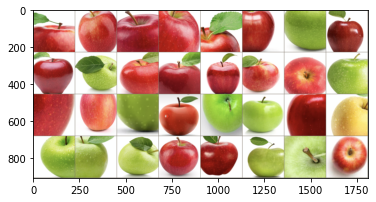

['freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples']


In [21]:
# transform 된 배치 이미지 시각화
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out)
print([class_names[x] for x in classes])

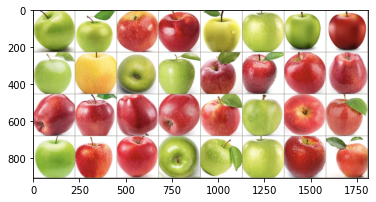

['freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples']


In [6]:
inputs, classes = next(iter(dataloaders['val']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out)
print([class_names[x] for x in classes])

In [7]:
train_images, train_classes = next(iter(dataloaders['train']))
test_images, test_classes = next(iter(dataloaders['val']))

print(type(train_images), type(test_images))
print(train_images.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([32, 3, 224, 224])


## torch.tensor 의 형변환 = permute().contiguous
## ndarray의 형변환 = view, reshape, transpose 

In [8]:
# train_images = train_images.permute(0,2,3,1).contiguous()
# test_images = test_images.permute(0,2,3,1).contiguous()

# print(train_images.shape, train_classes.shape)

''' SLIC 변환 시 이미지 형태를 ndarray로만 받고 있어서 (에러발생)
Tensor 형태를 ndarray형태로 바꾸어서 형변환 시켜주어야 함'''

' SLIC 변환 시 이미지 형태를 ndarray로만 받고 있어서 (에러발생)\nTensor 형태를 ndarray형태로 바꾸어서 형변환 시켜주어야 함'

In [9]:
# torch.Tensor type to np array type
train_images = train_images.detach().numpy()
train_images = (train_images*255).astype(np.uint8)
train_classes = train_classes.detach().numpy()

test_images = test_images.detach().numpy()
test_images = (test_images*255).astype(np.uint8)
test_classes = test_classes.detach().numpy()

print(type(train_images),type(test_classes))
print(train_images.shape, train_classes.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(32, 3, 224, 224) (32,)


In [10]:
# print(train_images.shape, train_classes.shape)
train_images = train_images.transpose(0,2,3,1)
test_images = test_images.transpose(0,2,3,1)
# train_images = train_images.permute(0,2,3,1).contiguous()         # ndarray에 permute는 에러가 뜸 (그런 인수를 갖고있지 않다)
# test_images = test_images.permute(0,2,3,1).contiguous()

print(train_images.shape, train_classes.shape)


(32, 3, 224, 224) (32,)
(32, 224, 224, 3) (32,)


(224, 224)


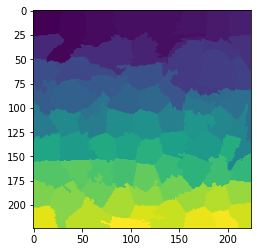

In [22]:
seg_slic = slic(train_images[2], num_segments=75, compactness=10, max_iterations=10, sigma=0)
print(seg_slic.shape)
plt.imshow(seg_slic)
plt.show()

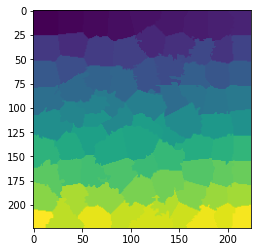

In [23]:
seg_slic = slic(test_images[1], num_segments=75, compactness=10, max_iterations=10, sigma=0)
plt.imshow(seg_slic)
plt.show()

array([[[ 61, 107, 161],
        [ 61, 107, 161],
        [ 61, 107, 161],
        ...,
        [ 61, 107, 161],
        [ 61, 107, 161],
        [ 61, 107, 161]],

       [[ 61, 107, 161],
        [ 61, 107, 161],
        [ 61, 107, 161],
        ...,
        [ 61, 107, 161],
        [ 61, 107, 161],
        [ 61, 107, 161]],

       [[ 61, 107, 161],
        [ 61, 107, 161],
        [ 61, 107, 161],
        ...,
        [ 61, 107, 161],
        [ 61, 107, 161],
        [ 61, 107, 161]],

       ...,

       [[ 57, 102, 156],
        [ 57, 102, 156],
        [ 57, 102, 156],
        ...,
        [ 61, 107, 161],
        [ 61, 107, 161],
        [ 61, 107, 161]],

       [[ 57, 102, 156],
        [ 57, 102, 156],
        [ 57, 102, 156],
        ...,
        [ 61, 107, 161],
        [ 61, 107, 161],
        [ 61, 107, 161]],

       [[ 61, 107, 161],
        [ 57, 102, 156],
        [ 57, 102, 156],
        ...,
        [ 61, 107, 161],
        [ 61, 107, 161],
        [ 61, 107, 161]]

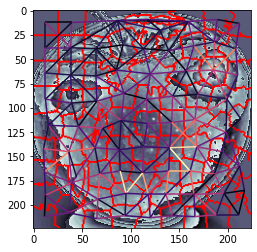

In [18]:
draw_rag2(train_images[2], seg_slic)

In [13]:
tr_imgs = [train_images[i] for i in range(10)]
tr_slic_img_list = []
for i in tr_imgs:
    tr_slic_imgs = draw_rag2(i, seg_slic)
    tr_slic_img_list.append(tr_slic_imgs)
    plt.close()
print(tr_slic_imgs.shape)
X_train_slic = np.array(tr_slic_img_list, dtype=np.float64)
X_train_slic = (X_train_slic*255).astype(np.uint8)
print(X_train_slic.shape)

(224, 224, 3)
(10, 224, 224, 3)


In [14]:
# X_train_slic = torchvision.transforms.ToTensor()
# print(type(X_train_slic))

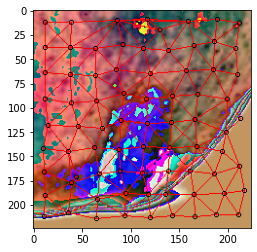

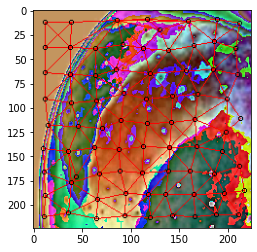

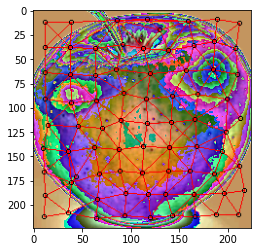

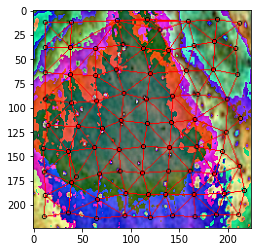

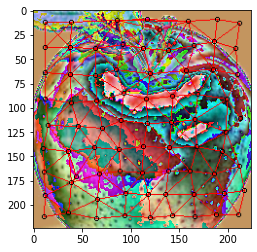

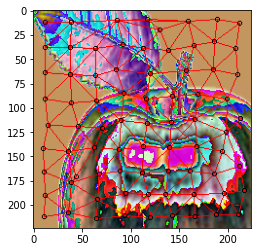

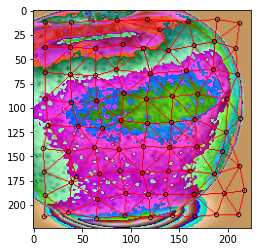

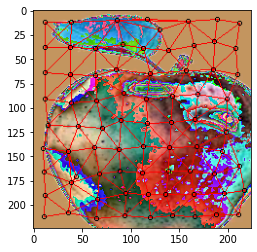

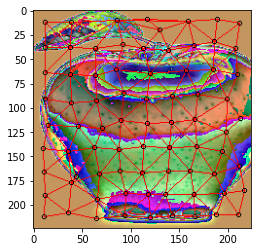

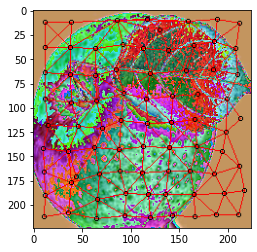

In [15]:
for a in range(10):
    plt.imshow(X_train_slic[a])
    plt.show()

array([[[ 61, 107, 161],
        [ 61, 107, 161],
        [ 61, 107, 161],
        ...,
        [ 61, 107, 161],
        [ 61, 107, 161],
        [ 61, 107, 161]],

       [[ 61, 107, 161],
        [ 61, 107, 161],
        [ 61, 107, 161],
        ...,
        [ 61, 107, 161],
        [ 61, 107, 161],
        [ 61, 107, 161]],

       [[ 61, 107, 161],
        [ 61, 107, 161],
        [ 61, 107, 161],
        ...,
        [ 61, 107, 161],
        [ 61, 107, 161],
        [ 61, 107, 161]],

       ...,

       [[ 57, 102, 147],
        [ 57, 102, 147],
        [ 57, 102, 147],
        ...,
        [ 61, 107, 161],
        [ 61, 107, 161],
        [ 61, 107, 161]],

       [[ 57, 102, 147],
        [ 57, 102, 147],
        [ 57, 102, 147],
        ...,
        [ 61, 107, 161],
        [ 61, 107, 161],
        [ 61, 107, 161]],

       [[ 57, 102, 147],
        [ 57, 102, 147],
        [ 57, 102, 147],
        ...,
        [ 61, 107, 161],
        [ 61, 107, 161],
        [ 61, 107, 161]]

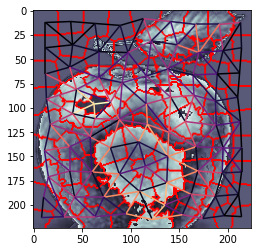

In [24]:
draw_rag2(test_images[1], seg_slic)

In [16]:
te_imgs = [test_images[i] for i in range(10)]
te_slic_img_list = []
for i in te_imgs:
    # seg = slic(i, 100, 5, 10 ,0)   
    te_slic_imgs = draw_rag2(i, seg_slic)
    # te_slic_imgs = cv2.resize(te_slic_imgs, (32, 32))
    te_slic_img_list.append(te_slic_imgs)
    plt.close()
X_test_slic = np.array(te_slic_img_list, dtype=np.float64)
X_test_slic = (X_test_slic*255).astype(np.uint8)

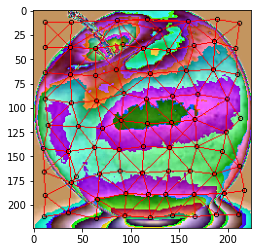

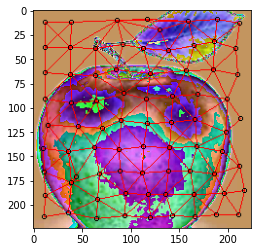

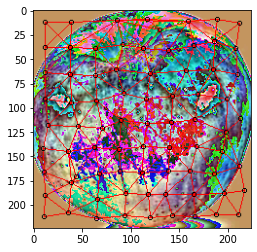

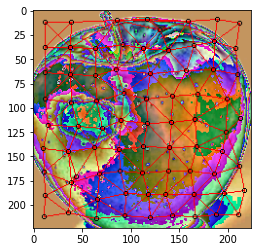

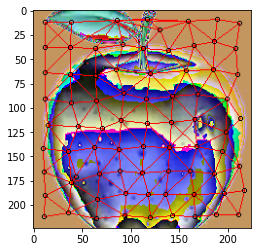

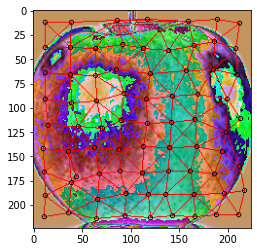

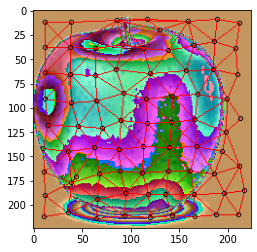

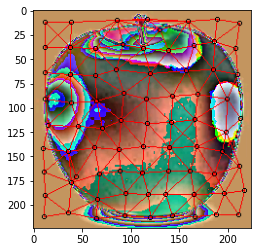

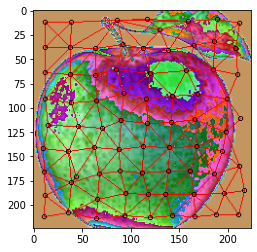

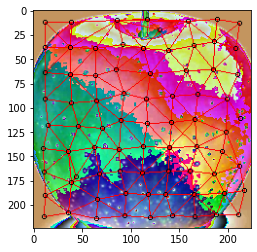

In [17]:
for a in range(10):
    plt.imshow(X_test_slic[a])
    plt.show()